# FCI calculations for H$_2$ molecule in the minimal basis

We will compare the fermionic and bosonic Hamiltonians representing the electronic structure of H$_2$ molecule in the minimal basis.
All the Hamiltonian matrices should be the same, so it is a way to check that our Hamiltonian mapping is correct.

## Prerequisite

Installation cells for Google Colab users.

In [ ]:
!pip install qutip
!pip install openfermion
!pip install openfermionpyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.7 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=c72438144e60ddb891b875caa3a31b1fcb252ceedb823aaa47b6de8ebd5bd08f
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 16.5 MB/s eta 0:00:00


In [ ]:
pip install seaborn

Import libaries.

In [ ]:
import qutip as qt
import numpy as np

from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator
from openfermion.linalg import get_sparse_operator, expectation
from openfermion.ops import FermionOperator
from openfermion.ops.representations import get_tensors_from_integrals
from openfermionpyscf import run_pyscf

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

Molecular data object after Hartree-Fock calculation.

In [ ]:
def h2mol_data(hhdis):
    """
    Molecular data for H2 molecule in a minimal basis.

    Argument:
    hhdis -- bond distance in Angstrom
    """

    # Parameters
    basis = "sto-3g"
    multiplicity = 1
    charge = 0

    # XYZ coordinates
    geometry = [("H", (0,0,0)), ("H", (0,0,hhdis))]

    # Define molecule
    molecule = MolecularData(geometry, basis, multiplicity, charge)

    # Run HF calculation
    hf_molecule = run_pyscf(molecule, run_scf=1)

    return hf_molecule

### Fermionic

Compute the molecular integrals to build the fermionic Hamiltonian.
Note that we choose to write the molecular electronic structure Hamiltonian as:

$$ H = h_{\text{nuc}}
+ \sum_{pq} h_q^p \: f_p^\dagger f_q
+ \frac{1}{2} \sum_{pqrs} v_{rs}^{pq} \: f_p^\dagger f_q^\dagger f_r f_s,
$$
whereas the `OpenFermion` convention is

$$ H = h_{\text{nuc}}
+ \sum_{pq} h_q^p \: f_p^\dagger f_q
+ \sum_{pqrs} h_{rs}^{pq} \: f_p^\dagger f_q^\dagger f_r f_s.
$$

In [ ]:
def h2mol_integrals(hhdis):
    """
    Hamiltonian coefficients in the bosonic representation.

    Argument:
    hhdis -- bond distance in Angstrom
    """

    # Molecular data
    hf_molecule = h2mol_data(hhdis)

    # HF energy
    ehf = hf_molecule.hf_energy

    # Nuclear repulsion scalar
    hnuc = hf_molecule.nuclear_repulsion

    # Electron intergals
    h1, h2 = get_tensors_from_integrals(hf_molecule.one_body_integrals, \
                                        hf_molecule.two_body_integrals)
    v2 = h2 * 2

    return ehf, hnuc, h1, v2

Compute the matrix elements
$ \langle p, q | \: H \: |r, s \rangle $.
The Slater determinants are:
$ | 0, 1 \rangle_F, | 0, 2 \rangle_F, | 0, 3 \rangle_F, | 1, 2 \rangle_F, | 1, 3 \rangle_F $, and $ | 2, 3 \rangle_F $.

In [ ]:
def ham_fermi_mat(hhdis):
    """
    Build the FCI Hamiltonian matrix in the fermionic representation.
    We will use OpenFermion.

    Argument:
    hhdis -- bond distance in Angstrom
    """

    # Molecular data
    hf_molecule = h2mol_data(hhdis)

    # Ham operator
    ham_op = get_fermion_operator(hf_molecule.get_molecular_hamiltonian())

    # Vacuum
    n_qubit = 4
    vac_state = np.zeros(2 ** n_qubit)
    vac_state[0] = 1.0

    # Ket operators
    ket_list = [FermionOperator('0^ 1^'), \
                FermionOperator('0^ 2^'), \
                FermionOperator('0^ 3^'), \
                FermionOperator('1^ 2^'), \
                FermionOperator('1^ 3^'), \
                FermionOperator('2^ 3^') ]

    # Bra operators
    bra_list = [FermionOperator('1 0'), \
                FermionOperator('2 0'), \
                FermionOperator('3 0'), \
                FermionOperator('2 1'), \
                FermionOperator('3 1'), \
                FermionOperator('3 2') ]

    # Hamiltonian
    M2 = np.zeros([6, 6])
    j = 0
    for bra in bra_list:
        j += 1
        k = 0
        for ket in ket_list:
            k += 1
            op_mat = get_sparse_operator( bra * ham_op * ket )
            M2[j-1, k-1] = np.real( expectation(op_mat, vac_state) )

    return M2

### Bosonic

We write the same Hamiltonian of dihydrogen molecule as a system of two qumodes or quantum harmonic oscillators (QHOs), as derived in the equation 46 of [arXiv: 2404.10222v2](https://arxiv.org/abs/2404.10222v2)

\begin{align}
H_B
&= g_1 |0, 0 \rangle \langle 0, 0 |
+ g_2 |0, 2 \rangle \langle 0, 2|
+ g_3 \big( |0, 1 \rangle \langle 0, 1|
+ |2, 0 \rangle \langle 2, 0| \big)  
+ g_4 \big( |1, 0, \rangle \langle 1, 0 |
+ |1, 1 \rangle \langle 1, 1| \big)  
\\
&+ g_5 \: \big( |0, 0 \rangle \langle 0, 2| + \text{h.c.} \big)
- g_5 \: \big( |2, 0 \rangle \langle 0, 1| + \text{h.c.} \big),
\end{align}
where $\{ g_j \}$ are functions of one-electron and two-electron integrals

\begin{align}
g_1
&= h^0_0 + h^1_1 + v^{01}_{10},
\\
g_2
&= 2 h^2_2 + v^{23}_{32},
\\
g_3
&= h^0_0 + h^2_2 + v^{02}_{20},
\\
g_4
&= h^0_0 + h^2_2 + v^{02}_{20} - v^{02}_{02},
\\
g_5
&= v^{02}_{20}.
\end{align}

This was the first time a molecular electronic structure Hamiltonian was represented as a bosonic Hamiltonian.


In [ ]:
def ham_bose_coeffs(h1, v2):
    """
    Hamiltonian coefficients in the bosonic representation.

    Arguments:
    h1 -- one-electron integrals
    v2 -- two-electron integrals
    """

    g1 = np.zeros([5])

    g1[0] = h1[0, 0] + h1[1, 1] + v2[0, 1, 1, 0]
    g1[1] = ( 2 * h1[2, 2] ) + v2[2, 3, 3, 2]
    g1[2] = h1[1, 1] + h1[3, 3] + v2[0, 2, 2, 0]
    g1[3] = h1[0, 0] + h1[2, 2] + v2[0, 2, 2, 0] - v2[0, 2, 0, 2]
    g1[4] = v2[0, 2, 0, 2]

    return g1

Compute the matrix elements
$ \langle p, q | \: H \: |r, s \rangle $.
The basis states are:
$ | 0, 0 \rangle_B, | 1, 0 \rangle_B, | 2, 0 \rangle_B, | 0, 1 \rangle_B, | 1, 1 \rangle_B $, and $ | 0, 2 \rangle_B $.

In [ ]:
def ham_bose_mat(hnuc, g1):
    """
    Build the FCI Hamiltonian matrix in the bosonic representation.
    We will use QuTip.

    Arguments:
    hnuc -- nuclear repulsion scalar
    g1 -- bosonic Hamiltonian coefficients
    """

    # Scalar part of H
    ham_bose = hnuc * qt.tensor( qt.qeye(3), qt.qeye(3) )

    # Symmetric part of H
    ham_bose += g1[0] * qt.tensor( qt.basis(3, 0) * qt.basis(3, 0).dag(), \
                                   qt.basis(3, 0) * qt.basis(3, 0).dag() )
    ham_bose += g1[1] * qt.tensor( qt.basis(3, 0) * qt.basis(3, 0).dag(), \
                                   qt.basis(3, 2) * qt.basis(3, 2).dag() )
    ham_bose += g1[2] * qt.tensor( qt.basis(3, 0) * qt.basis(3, 0).dag(), \
                                   qt.basis(3, 1) * qt.basis(3, 1).dag() )
    ham_bose += g1[2] * qt.tensor( qt.basis(3, 2) * qt.basis(3, 2).dag(), \
                                   qt.basis(3, 0) * qt.basis(3, 0).dag() )
    ham_bose += g1[3] * qt.tensor( qt.basis(3, 1) * qt.basis(3, 1).dag(), \
                                   qt.basis(3, 0) * qt.basis(3, 0).dag() )
    ham_bose += g1[3] * qt.tensor( qt.basis(3, 1) * qt.basis(3, 1).dag(), \
                                   qt.basis(3, 1) * qt.basis(3, 1).dag() )
    # Transition part of H
    ham_bose += g1[4] * qt.tensor( qt.basis(3, 0) * qt.basis(3, 0).dag(), \
                                   qt.basis(3, 0) * qt.basis(3, 2).dag() )
    ham_bose += g1[4] * qt.tensor( qt.basis(3, 0) * qt.basis(3, 0).dag(), \
                                   qt.basis(3, 2) * qt.basis(3, 0).dag() )
    ham_bose -= g1[4] * qt.tensor( qt.basis(3, 2) * qt.basis(3, 0).dag(), \
                                   qt.basis(3, 0) * qt.basis(3, 1).dag() )
    ham_bose -= g1[4] * qt.tensor( qt.basis(3, 0) * qt.basis(3, 2).dag(), \
                                   qt.basis(3, 1) * qt.basis(3, 0).dag() )


    # States
    ket_list = [qt.tensor( qt.basis(3, 0), qt.basis(3, 0) ), \
                qt.tensor( qt.basis(3, 1), qt.basis(3, 0) ), \
                qt.tensor( qt.basis(3, 2), qt.basis(3, 0) ), \
                qt.tensor( qt.basis(3, 0), qt.basis(3, 1) ), \
                qt.tensor( qt.basis(3, 1), qt.basis(3, 1) ), \
                qt.tensor( qt.basis(3, 0), qt.basis(3, 2) ) ]

    # Hamiltonian matrix
    M2 = np.zeros([6, 6])
    j = 0
    for bra in ket_list:
        j += 1
        k = 0
        for ket in ket_list:
            k += 1
            M2[j-1, k-1] = np.real( ham_bose.matrix_element( bra.dag(), ket) )

    return M2

## Tests

In [ ]:
hhdis = 0.7414
ehf, hnuc, h1, v2 = h2mol_integrals(hhdis)
g1 = ham_bose_coeffs(h1, v2)

MF = ham_fermi_mat(hhdis)
MB = ham_bose_mat(hnuc, g1)

In [ ]:
print("ehf-orig:", ehf)
print("h00-ferm:", MF[0, 0])
print("h00-bose:", MB[0, 0])

ehf-orig: -1.1166843870853405
h00-ferm: -1.116684387085341
h00-bose: -1.116684387085341


In [ ]:
print("H-fermi:")
print(MF)
print("------------")
print("H-bose:")
print(MB)

H-fermi:
[[-1.11668439  0.          0.          0.          0.          0.18128881]
 [ 0.         -0.53247901  0.          0.          0.          0.        ]
 [ 0.          0.         -0.3511902  -0.18128881  0.          0.        ]
 [ 0.          0.         -0.18128881 -0.3511902   0.          0.        ]
 [ 0.          0.          0.          0.         -0.53247901  0.        ]
 [ 0.18128881  0.          0.          0.          0.          0.45925033]]
------------
H-bose:
[[-1.11668439  0.          0.          0.          0.          0.18128881]
 [ 0.         -0.53247901  0.          0.          0.          0.        ]
 [ 0.          0.         -0.3511902  -0.18128881  0.          0.        ]
 [ 0.          0.         -0.18128881 -0.3511902   0.          0.        ]
 [ 0.          0.          0.          0.         -0.53247901  0.        ]
 [ 0.18128881  0.          0.          0.          0.          0.45925033]]


In [ ]:
print("H-bose coefficients:")
print(g1)

H-bose coefficients:
[-1.83043838 -0.25450366 -1.06494419 -1.246233    0.18128881]


## Scripts

### Heatmaps

Print heatmaps of bosonic and fermionic Hamiltonians for the equilibrium H-H bond distance.

In [ ]:
# Distance
diseq = 0.7414 # Angstrom

# Hamiltonian coefficients
ehf, hnuc, h1, v2 = h2mol_integrals(diseq)
g1 = ham_bose_coeffs(h1, v2)

In [ ]:
# Hamiltonian matrices
M1 = ham_fermi_mat(diseq)
M2 = ham_bose_mat(hnuc, g1)

In [ ]:
# Seaborn themes
sns.set_theme(style="white")

# Custom colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

<Axes: >

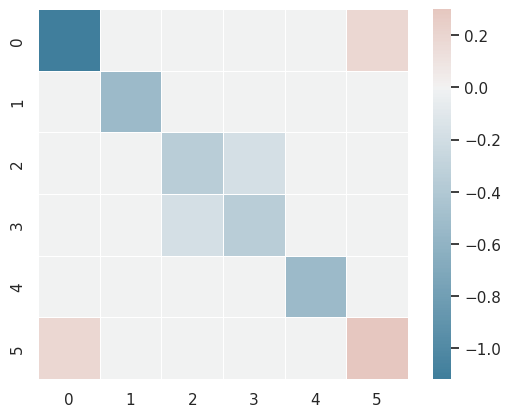

In [ ]:
# Heatmap #1
sns.heatmap(M1, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5)

<Axes: >

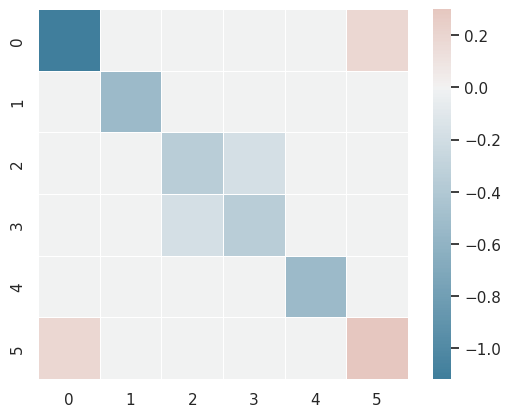

In [ ]:
# Heatmap #2
sns.heatmap(M2, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5)

### Bosonic Hamiltonian coefficients

Plot the $\{ g_p \}$ values with respect to H-H bond distances.

In [ ]:
# Parameters
disin = 0.2 # initial distance
deltadis = 0.02 # change in distance
npoints = 151 # number of points

# Initialize
gmat = np.zeros([npoints, 5]) # array for coefficients
dvec = np.zeros([npoints]) # array for distances
dvec[0] = disin # initial distance

# Start the loop
for j in range(npoints):
    # Print
    print("distance:", dvec[j])
    print("------------------")
    # Get coefficients
    ehf, hnuc, h1, v2 = h2mol_integrals(dvec[j])
    gmat[j, :] = ham_bose_coeffs(h1, v2)
    # Exit condition
    if j == npoints - 1:
        break
    # Update
    dvec[j + 1] = dvec[j] + deltadis

distance: 0.2
------------------
distance: 0.22
------------------
distance: 0.24
------------------
distance: 0.26
------------------
distance: 0.28
------------------
distance: 0.30000000000000004
------------------
distance: 0.32000000000000006
------------------
distance: 0.3400000000000001
------------------
distance: 0.3600000000000001
------------------
distance: 0.3800000000000001
------------------
distance: 0.40000000000000013
------------------
distance: 0.42000000000000015
------------------
distance: 0.44000000000000017
------------------
distance: 0.4600000000000002
------------------
distance: 0.4800000000000002
------------------
distance: 0.5000000000000002
------------------
distance: 0.5200000000000002
------------------
distance: 0.5400000000000003
------------------
distance: 0.5600000000000003
------------------
distance: 0.5800000000000003
------------------
distance: 0.6000000000000003
------------------
distance: 0.6200000000000003
------------------
distance: 

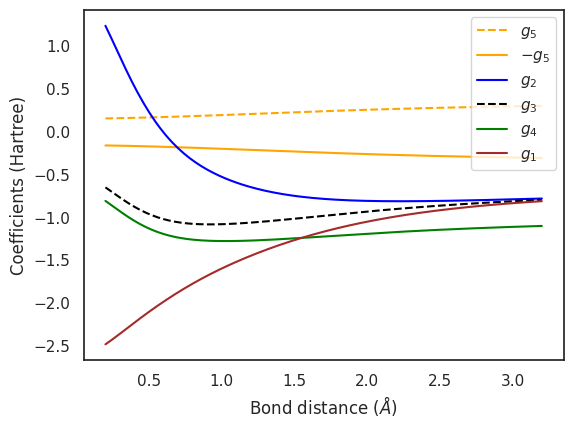

In [ ]:
# Figure and axes
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 16})
plt.subplots_adjust(left=0.15, bottom=0.15)

# Axis labels and title
ax.set_xlabel('Bond distance ($\AA$)')
ax.set_ylabel('Coefficients (Hartree)')
#ax.set_title('Bosonic Hamiltonian coefficients for dihydrogen')

# Plot the curves
ax.plot(dvec, gmat[:, 4], '--', color='orange', label='$g_5$')
ax.plot(dvec, -gmat[:, 4], '', color='orange', label='$- g_5$')
ax.plot(dvec, gmat[:, 1], '', color='blue', label='$g_2$')
ax.plot(dvec, gmat[:, 2], '--', color='black', label='$g_3$')
ax.plot(dvec, gmat[:, 3], '', color='green', label='$g_4$')
ax.plot(dvec, gmat[:, 0], '', color='brown', label='$g_1$')

# Legend
ax.legend(loc='best')

# Save
plt.savefig('bosonic_coeffs.pdf', dpi=500)
#files.download('bosonic_coeffs.png')

# Show the plot
plt.show()